# Modeling: Regression
- Use n-1 year on-field stats and n year for talent stats to predict year n results
- Treat data as set of features at start of each year and try to regress on various outcomes

In [10]:
!pip install --q xgboost

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [24]:
df = pd.read_csv('data/working_df.csv')
df.head()

,team,team_id,year,conference,games_played,expected_wins,wins,losses,win_pct,prev_win_pct,...,usages,off_drives,def_drives,off_explode,def_explode,off_ppa,def_ppa,off_success_rate,def_success_rate,coach
0,Air Force,2005,2014,Mountain West,13,9.7,10,3,0.769231,0.166667,...,0.684,139,137,0.860561,0.902638,0.096601,0.214295,0.439644,0.518913,Troy Calhoun
1,Air Force,2005,2015,Mountain West,14,8.2,8,6,0.571429,0.769231,...,0.646,165,161,1.089935,1.425767,0.207059,0.138795,0.451837,0.375831,Troy Calhoun
2,Air Force,2005,2016,Mountain West,13,9.4,10,3,0.769231,0.571429,...,0.625,177,173,1.154045,1.549206,0.272449,0.172654,0.474216,0.357631,Troy Calhoun
3,Air Force,2005,2017,Mountain West,12,4.4,5,7,0.416667,0.769231,...,0.556,147,148,1.027586,1.534094,0.227697,0.158770,0.483333,0.366048,Troy Calhoun
4,Air Force,2005,2018,Mountain West,12,6.4,5,7,0.416667,0.416667,...,0.720,138,139,1.095699,1.374592,0.235542,0.247661,0.488398,0.422096,Troy Calhoun


In [6]:
df.columns

Index(['team', 'team_id', 'year', 'conference', 'games_played',
       'expected_wins', 'wins', 'losses', 'win_pct', 'prev_win_pct', 'elo',
       'fpi', 'conference_rating', 'recruiting_rank', 'recruiting_rating',
       'blue_chip', 'blue_chip_ratio', 'passing_usage', 'rushing_usage',
       'usages', 'off_drives', 'def_drives', 'off_explode', 'def_explode',
       'off_ppa', 'def_ppa', 'off_success_rate', 'def_success_rate', 'coach'],
      dtype='object')

#### Split Training/Testing Sets
- We'll split by hand so we can do things in temporal order just to be safe
- 2014 - 2023 is 10 years of data so we'll take 2014 to 2021 for trainig

In [25]:
split_year = 2022
df_train = df[df.year <= split_year]
df_test = df[df.year > split_year]

- Can't include coach_win_pct when doing regression

In [76]:
# Grab features you want
X_cols = ['elo', 'fpi', 'prev_win_pct', 'conference_rating', 'recruiting_rank', 'recruiting_rating', 
        'blue_chip_ratio', 'usages', 'off_ppa', 'off_success_rate', 'passing_usage']
# Grab the target. Be careful as y_train needs to be a Pandas series or 1D numpy array
y_cols = 'win_pct'

X_train, X_test = df_train[X_cols], df_test[X_cols]
y_train, y_test = df_train[y_cols], df_test[y_cols]

#### Feature Selection

In [77]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, max_depth=4)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, n_estimators=500)

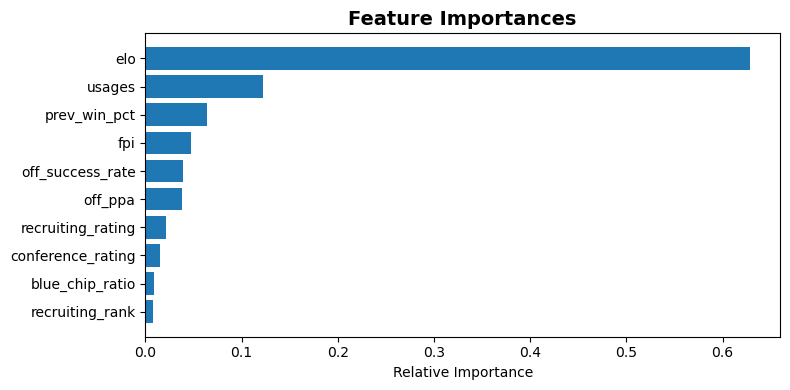

In [78]:
# Use my premade method for graphing feature importance
def graph_feature_importance(model, data):
    """
    model = trained model object from sklearn
    data = Usually X_train
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[-10:] # Get top 10 most important features
    features = data.columns
    f, ax = plt.subplots(figsize=(8, 4))
    plt.title('Feature Importances', fontweight='bold', fontsize=14)
    plt.barh(range(len(indices)), importances[indices])#, color = colormap.colors)
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.savefig('images/feature_imporances.png')
    plt.show()

graph_feature_importance(rf, X_train)

Let's setup a pipeline to scale our features

In [80]:
from sklearn.preprocessing import StandardScaler

# Scale data, retaining original column titles and structure. Scale on TRAINING data
scaler = StandardScaler()
# Fit and transform on TRAINING data
X_train_scl = pd.DataFrame(scaler.fit_transform(X_train.copy()), 
                            columns = X_train.columns)
# Now transform TEST data
X_test_scl = pd.DataFrame(scaler.transform(X_test.copy()),
                            columns = X_test.columns)

X_train_scl.head()

,elo,fpi,prev_win_pct,conference_rating,recruiting_rank,recruiting_rating,blue_chip_ratio,usages,off_ppa,off_success_rate,passing_usage
0,-1.505966,-1.448683,-1.585774,-0.915332,1.271325,-1.436965,-0.649317,0.366327,-0.808335,0.214708,0.407974
1,-0.271254,-0.314176,1.133057,-0.863135,1.560302,-1.432615,-0.649317,0.180041,0.369934,0.495535,-1.105213
2,0.074192,0.042319,0.240553,-0.780406,1.323866,-1.199160,-0.649317,0.077093,1.067458,1.010974,-1.148887
3,0.279407,-0.035338,1.133057,-0.770558,1.192513,-1.108896,-0.649317,-0.261163,0.590076,1.220955,1.014276
4,-0.305457,-0.659486,-0.457748,-1.054198,1.534031,-1.206229,-0.649317,0.542809,0.673764,1.337600,0.734246


In [81]:
X_test_scl.head()

,elo,fpi,prev_win_pct,conference_rating,recruiting_rank,recruiting_rating,blue_chip_ratio,usages,off_ppa,off_success_rate,passing_usage
0,0.877952,0.195539,1.133057,-1.477689,1.061159,-0.842453,-0.649317,-1.697527,1.338709,1.157309,-1.434055
1,-1.222085,-1.500186,-1.585774,-1.762314,1.192513,-1.012832,-0.649317,0.729095,-0.623024,-0.099171,1.034828
2,2.290517,2.090354,1.480142,1.507569,-1.644719,2.735853,3.659151,-1.084743,1.418136,0.948603,-1.143749
3,0.279407,-0.073160,-0.081740,-0.501550,0.430664,-0.273136,-0.649317,-1.065134,0.925687,0.591841,-1.449469
4,-0.469629,-0.267663,-0.457748,0.507793,-0.620163,0.501360,-0.239268,1.542871,1.059052,0.961797,1.037398


### BELOW IS IN PROGRESS

In [82]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [126]:
# Make kfold object
kfold = KFold(5, random_state=123, shuffle=True)

mses = np.zeros((5,5))
i = 0
for i, (train_index, test_index) in enumerate(kfold.split(X_train)):

    X_tt, y_tt = X_train_scl.iloc[train_index], y_train.iloc[train_index]
    X_ho, y_ho = X_train_scl.iloc[test_index], y_train.iloc[test_index]
    X_ho_base, y_ho_base = X_train.iloc[test_index], y_train.iloc[test_index]

    # Baseline model, take previous winning percentage
    pred0 = X_ho_base['prev_win_pct']

    # Declare Models
    model1 = LinearRegression() # All features
    model2 = LinearRegression() # Just ELO
    model3 = RandomForestRegressor()
    model4 = XGBRegressor()

    # Train Models
    model1.fit(X_tt, y_tt)
    model2.fit(X_tt[['elo']], y_tt)
    model3.fit(X_tt, y_tt)
    model4.fit(X_tt, y_tt)

    # Get predictions
    pred1 = model1.predict(X_ho)
    pred2 = model2.predict(X_ho[['elo']])
    pred3 = model3.predict(X_ho)
    pred4 = model4.predict(X_ho)

    mses[0,i] = mean_squared_error(y_ho_base, pred0)
    mses[1,i] = mean_squared_error(y_ho, pred1)
    mses[2,i] = mean_squared_error(y_ho, pred2)
    mses[3,i] = mean_squared_error(y_ho, pred3)
    mses[4,i] = mean_squared_error(y_ho, pred4)
    

In [127]:
np.mean(mses, axis=1)

array([0.04720243, 0.03004488, 0.03310724, 0.02938772, 0.03410427])

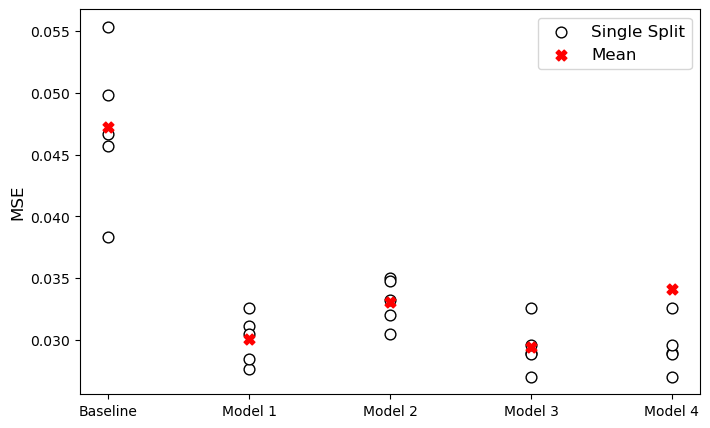

In [133]:
## From Erdos lecture, this figure will graphically compare the performance
plt.figure(figsize=(8,5))

plt.scatter(np.zeros(5), mses[0,:], s=60, c='white', edgecolor='black', label="Single Split")
plt.scatter(np.ones(5), mses[1,:], s=60, c='white', edgecolor='black')
plt.scatter(2*np.ones(5), mses[2,:], s=60, c='white', edgecolor='black')

plt.scatter(3*np.ones(5), mses[3,:], s=60, c='white', edgecolor='black')

plt.scatter(4*np.ones(5), mses[3,:], s=60, c='white', edgecolor='black')

plt.scatter([0,1,2,3,4], np.mean(mses, axis=1), s=60, c='r',marker='X',label="Mean")

plt.legend(fontsize=12)

plt.xticks([0,1,2,3, 4],["Baseline", "Model 1", "Model 2", "Model 3", "Model 4"], fontsize=10)
plt.yticks(fontsize=10)

plt.ylabel("MSE", fontsize=12)
plt.savefig('images/cross-val-mses.png')
plt.show()

### Testing the Model
- Take the best performing model and use for prediction

In [129]:
y_pred = model3.predict(X_test_scl)
mean_squared_error(y_pred, y_test)

0.028260487300470948

To interpret the error, we did the following:
1. Multiply the win percentage by 12 season games and round to the nearest number of wins
2. Find the RMSE of the predicted vs. actual wins
We find an RMSE of around 1.95 wins so we're predicting a number of wins to within just under +/- 2 games.

In [130]:
np.sqrt(mean_squared_error(np.round(y_test*12,0), np.round(y_pred*12, 0)))

1.9557607215607946

Compared to the baseline model of

In [131]:
y_pred_base = X_test['prev_win_pct']
np.sqrt(mean_squared_error(np.round(y_test*12,0), np.round(y_pred_base*12, 0)))

2.1756225162774294

So we see an improvement over the baseline, but not by much. About a 10.6% improvement over the baseline.

In [134]:
def percent_diff(a, b):
    return np.abs((a - b) / ((a + b) / 2)) * 100

percent_diff(np.sqrt(mean_squared_error(np.round(y_test*12,0), np.round(y_pred*12, 0))),
np.sqrt(mean_squared_error(np.round(y_test*12,0), np.round(y_pred_base*12, 0))))

10.643495510316251